In [ ]:
import ast

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
from matplotlib.offsetbox import (OffsetImage, AnnotationBbox)
import ms_pred.magma.fragmentation as fragmentation
from pathlib import Path
import subprocess
import pickle

import ms_pred.common as common
from ms_pred.retrieval.retrieval_benchmark import cos_dist_bin, cos_dist_hun

In [ ]:
%cd /home/runzhong/ms-pred

In [ ]:
python_path = '/home/runzhong/mambaforge/envs/ms-main/bin/python'
pred_file = 'src/ms_pred/dag_pred/predict_smis.py'
label_pattern = '/home/runzhong/ms_collaborators/erin_neu/label_{}.tsv'
gen_ckpt = '/home/runzhong/ms-models/iceberg_results_20240512/dag_nist20/split_1_rnd1/version_0/best.ckpt'
inten_ckpt = '/home/runzhong/ms-models/iceberg_results_20240512/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt'
save_dir = Path('/home/runzhong/ms_collaborators/erin_neu/result')
real_spec_dir = Path('/home/runzhong/ms_collaborators/erin_neu/specs')
ppm = 20

all_metadata = {}

In [ ]:
def mol_ok(mol):
    try:
        Chem.SanitizeMol(mol)
        return True
    except ValueError:
        return False
    
def ring_OK(mol):
    if not mol.HasSubstructMatch(Chem.MolFromSmarts("[R]")):
        return True

    ring_allene = mol.HasSubstructMatch(Chem.MolFromSmarts("[R]=[R]=[R]"))

    cycle_list = mol.GetRingInfo().AtomRings()
    max_cycle_length = max([len(j) for j in cycle_list])
    macro_cycle = max_cycle_length > 6

    double_bond_in_small_ring = mol.HasSubstructMatch(
        Chem.MolFromSmarts("[r3,r4]=[r3,r4]")
    )

    return not ring_allene and not macro_cycle and not double_bond_in_small_ring

In [ ]:
def generate_candidates(base_mols, all_rxn_smarts):
    iterable = True
    try:
        _ = iter(base_mols)
    except TypeError as te:
        iterable = False
    
    if not iterable:
        base_mols = [base_mols]
            
    candidate_pathways = []
    all_new_mols = []
    for rxn_smarts in all_rxn_smarts:
        rxn = AllChem.ReactionFromSmarts(rxn_smarts)
        for base_mol in base_mols:
            new_mol_trial = rxn.RunReactants((base_mol,))
            new_mols = np.array([mol[0] for mol in new_mol_trial if mol_ok(mol[0]) and ring_OK(mol[0])])
            new_inchikey = np.array([Chem.MolToInchiKey(mol) for mol in new_mols])
            _, indices = np.unique(new_inchikey, return_index=True)
            new_mols = new_mols[indices]
            candidate_pathways += [(Chem.MolToSmiles(base_mol), Chem.MolToSmiles(m)) for m in new_mols]
            all_new_mols += new_mols.tolist()
            
    new_inchikey = np.array([Chem.MolToInchiKey(mol) for mol in all_new_mols])
    _, indices = np.unique(new_inchikey, return_index=True)
    all_new_mols = np.array(all_new_mols)[indices]
    return all_new_mols, candidate_pathways

def add_atom(base_mols, new_atom='O'):  # Hydrogen is ignored, new_atom='C' means 'CH2'
    all_rxn_smarts = [
        "[*:1]>>[*:1]X".replace("X", new_atom),  # append
        # "[*:1]-[*:2]>>[*:1]X[*:2]".replace("X", new_atom),  # insert
    ]
    if new_atom == 'O':
        all_rxn_smarts.append(
            "[*:1]=[*:2]>>[*:1]1X[*:2]1".replace("X", new_atom),  # double bond -> C-O-C ring
        )
    return generate_candidates(base_mols, all_rxn_smarts)

def add_unsaturation(base_mols):  # add double bond or add one ring
    all_rxn_smarts = [
        "[*:1]-[*:2]>>[*:1]=[*:2]",  # single bond -> double bond
        "[*:1]=[*:2]>>[*:1]#[*:2]",  # double bond -> triple bond
        "[*;!r;!H0:1]~[*;!r:2]~[*;!r;!H0:3]>>[*:1]1~[*:2]~[*:3]1",  # rings
        "[*;!r;!H0:1]~[*!r:2]~[*!r:3]~[*;!r;!H0:4]>>[*:1]1~[*:2]~[*:3]~[*:4]1",
        "[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*;!r;!H0:5]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]1",
        "[*;!r;!H0:1]~[*!r:2]~[*:3]~[*:4]~[*!r:5]~[*;!r;!H0:6]>>[*:1]1~[*:2]~[*:3]~[*:4]~[*:5]~[*:6]1",
    ]
    return generate_candidates(base_mols, all_rxn_smarts)

## Beamsearch pipeline

In [ ]:
# cmpd1 structure (starting material)
cmpd1_smi = 'C[C@]12C(C[C@@H](O)CC2)=CC[C@]3([H])[C@]1([H])CC[C@@]4(C)[C@@]3([H])CC[C@@H]4[C@H](C)[C@H](O)C/C(C)=C(C)/C'
cmpd1_mol = Chem.MolFromSmiles(cmpd1_smi)
cmpd1_smi = Chem.MolToSmiles(cmpd1_mol, isomericSmiles=False)
cmpd1_mol = Chem.MolFromSmiles(cmpd1_smi)
cmpd1_mol

In [ ]:
pathways = []
head_mols = [cmpd1_mol]
dist_cache = {}
beam_width = 15

for added_smi, precursor, adduct, spec_name, replicates_id in [
    ('O', 413.3415, '[M+H-H2O]+', 'cmpd5-ms2', ('1', '2')),
    ('O', 429.336, '[M+H-H2O]+', 'cmpd35-ms2', ('1', '2')),
    ('C(=O)C', 471.3469, '[M+H-H2O]+', 'cmpd7-ms2', ('1', '2')),
]:
    # generate candidates
    cmpd_candidates, one_step_pairs = add_atom(head_mols, added_smi)
    cmpd_candidates = [Chem.MolToSmiles(_) for _ in cmpd_candidates]
    if len(pathways) == 0:
        pathways = np.array([[p[-1]] for p in one_step_pairs])
    else:
        new_pathways = []
        for cmpd1, cmpd2 in one_step_pairs:
            for p in pathways:
                if common.inchikey_from_smiles(p[-1]) == common.inchikey_from_smiles(cmpd1):
                    new_pathways.append(list(p) + [cmpd2])
        pathway_inchikey = ['-'.join([common.inchikey_from_smiles(s) for s in p]) for p in new_pathways]
        _, indices = np.unique(pathway_inchikey, return_index=True)
        pathways = np.array(new_pathways)[indices]
    print(f'name={spec_name}, num candidates={len(cmpd_candidates)}, num pathways={len(pathways)}')
    
    df_dict = []
    for smi in cmpd_candidates:
        df_dict.append({
            'spec': spec_name,
            'smiles': smi,
            'ionization': adduct,
            'precursor': precursor,
            'collision_energies': ['30'],
        })
    df = pd.DataFrame(df_dict)
    df.to_csv(label_pattern.format(spec_name), sep='\t')
    
    # run iceberg
    cmd = (f'''{python_path} {pred_file} \\
           --num-workers 32 \\
           --dataset-labels {label_pattern.format(spec_name)} \\
           --sparse-out \\
           --sparse-k 150 \\
           --max-nodes 150 \\
           --gen-checkpoint {gen_ckpt} \\
           --inten-checkpoint {inten_ckpt} \\
           --save-dir {save_dir / spec_name} \\
           --binned-out \\
           --adduct-shift''')
    #subprocess.run(cmd, shell=True)
    
    binned_preds = pickle.load(open(save_dir / spec_name / 'binned_preds.p', 'rb'))
    smiles = np.array(binned_preds['smiles'])
    spec_names = np.array(binned_preds['spec_names'])
    pred_specs = np.array(binned_preds['preds'])
    num_bins = binned_preds['num_bins']
    
    # score the molecules
    dist = []
    for name_suffix in replicates_id:
        spec_df = pd.read_csv(real_spec_dir / f'{spec_name}-{name_suffix}.csv', header=2)
        ref_spec = common.process_spec_file({'parentmass': precursor}, [('30', np.array(spec_df))], merge_specs=False)
        ref_binned = {k: common.bin_spectra([v], num_bins)[0] for k, v in ref_spec.items()}
        dist.append(cos_dist_bin(pred_specs, ref_binned, ignore_peak=(precursor-1) * 10))
    dist = np.array(dist)
    #dist_rank = np.argsort(np.argsort(dist.mean(axis=0))) # get the ranking of each mol
    for smi, d in zip(smiles, dist.mean(axis=0)):
        dist_cache[common.inchikey_from_smiles(smi)] = d

    # score the pathways
    pathway_dist = []
    for p in pathways:
        dist_sum = np.sum([dist_cache[common.inchikey_from_smiles(smi)] for smi in p])
        pathway_dist.append(dist_sum)
    
    # get the topk pathway
    if added_smi == 'O':
        topk_indices = np.argsort(pathway_dist)[:beam_width]
    else:
        topk_indices = np.argsort(pathway_dist)[:30]
    pathways = pathways[topk_indices]
    head_mols = [Chem.MolFromSmiles(p[-1]) for p in pathways] 

In [ ]:
legends = []
for rnk, pathway in enumerate(pathways):
    for smi in pathway:
        d = dist_cache[common.inchikey_from_smiles(smi)]
        legend = f"top{rnk+1} cos_dis={d:.3f} mass={common.mass_from_smi(smi):.3f}"
        legends.append(legend)
Draw.MolsToGridImage([Chem.MolFromSmiles(m) for p in pathways for m in p], molsPerRow=len(pathways[0]), subImgSize=(250,250), legends=legends, maxMols=60)

## Generate candidates by enumeration

In [ ]:
cmpd1_precursor = 'C[C@]12C(C[C@@H](O)CC2)=CC[C@]3([H])[C@]1([H])CC[C@@]4(C)[C@@]3([H])CC[C@@H]4[C@H](C)CC/C(C)=C(C)/C'
cmpd1_precursor = Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(cmpd1_precursor), isomericSmiles=False))
cmpd1_ambiguous, _ = add_atom(cmpd1_precursor, 'O')
cmpd1_ambiguous = [Chem.MolToSmiles(_) for _ in cmpd1_ambiguous]

cmpd1_metadata = {
    "cmpd_name": "cmpd1",
    "precursors": (397.3465,),
    "adducts": ('[M+H-H2O]+',),
    "spec_names": ('cmpd1-ms2',),
    "replicate_suffix": ('1', '2', '3'),
    "cmpd_candidates": cmpd1_ambiguous,
}

all_metadata['cmpd1'] = cmpd1_metadata

In [ ]:
cmpd5_candidates, _ = add_atom(cmpd1_mol, 'O')
cmpd5_candidates = [Chem.MolToSmiles(_) for _ in cmpd5_candidates]

cmpd5_metadata = {
    "cmpd_name": "cmpd5",
    "precursors": (413.3415,),
    "adducts": ('[M+H-H2O]+',),
    "spec_names": ('cmpd5-ms2',),
    "replicate_suffix": ('1', '2'),
    "cmpd_candidates": cmpd5_candidates,
}

all_metadata['cmpd5'] = cmpd5_metadata

In [ ]:
cmpd5_smi = 'CC(C)=C(C)CC(O)C(C)C1CCC2C3CC=C4CC(O)CC(O)C4(C)C3CCC12C'
cmpd35_candidates, _ = add_atom(Chem.MolFromSmiles(cmpd5_smi), 'O')
cmpd35_candidates = [Chem.MolToSmiles(_) for _ in cmpd35_candidates]

cmpd35_metadata = {
    "cmpd_name": "cmpd35",
    "precursors": (429.336,),
    "adducts": ('[M+H-H2O]+',),
    "spec_names": ('cmpd35-ms2',),
    "replicate_suffix": ('1', '2'),
    "cmpd_candidates": cmpd35_candidates,
}

all_metadata['cmpd35'] = cmpd35_metadata

In [ ]:
with open('/home/runzhong/ms_collaborators/erin_neu/cpd36_from_cpd5_3_enzymes.smi') as f:
    cmpd36_candidates = f.readlines()[0]
    cmpd36_candidates = ast.literal_eval(cmpd36_candidates)
    
cmpd36_candidates = [Chem.MolToSmiles(Chem.MolFromSmiles(cand), isomericSmiles=False) for cand in cmpd36_candidates]

# Erin's hypothesized structures. 18 out of 24 are not included in Itai's enumeration (2 max steps)
hyp36s = ['C[C@]12C(C[C@@H](O)CC2O)=CC[C@]3([H])[C@]1([H])CC[C@@]4(C)[C@@]3([H])CCC4[C@H](C)C5OC(C(C)=C(C)C5)=O', # guess 1
          'C[C@]12C(CC(CC2=O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)[C@H](O)C/C(C)=C(CO)/C', # guess 2 - C26 hydroxyl
          'C[C@]12C(C(O)C(CC2=O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)[C@H](O)C/C(C)=C(C)/C', # C4 hydroxyl
          'C[C@]12C(CC(CC2=O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)[C@H](O)C/C(C)=C(C)/C(O)', # C27 hydroxyl
          'C[C@]12C(CC(CC2=O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@@](C)(O)[C@H](O)C/C(C)=C(C)/C', # C20 hydroxyl
          'C[C@]12C(CC(CC2=O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@]4(O)[C@H](C)[C@H](O)C/C(C)=C(C)/C', # C17 hydroxyl
          'C[C@]12C(CC(CC2=O)=O)=CCC3C1CC[C@@]4(C)C3(O)CC[C@@H]4[C@H](C)[C@H](O)C/C(C)=C(C)/C', # C14 hydroxyl
          'C[C@]12C(CC(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(C/C(C)=C(CO)/C)=O', # guess 3 - C26 hydroxyl
          'C[C@]12C(C(O)C(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(C/C(C)=C(C)/C)=O', # C4 hydroxyl
          'C[C@]12C(CC(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(C/C(C)=C(C)/C(O))=O', # C27 hydroxyl
          'C[C@]12C(CC(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@@](C)(O)C(C/C(C)=C(C)/C)=O', # C20 hydroxyl
          'C[C@]12C(CC(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@]4(O)[C@H](C)C(C/C(C)=C(C)/C)=O', # C17 hydroxyl
          'C[C@]12C(CC(CC2O)=O)=CCC3C1CC[C@@]4(C)C3(O)CC[C@@H]4[C@H](C)C(C/C(C)=C(C)/C)=O', # C14 hydroxyl
          'C[C@]12C(CC(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(O)C/C(C)=C(C=O)/C', # guess 4 - C26 hydroxyl
          'C[C@]12C(C(=O)C(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(O)C/C(C)=C(C)/C', # C4 hydroxyl
          'C[C@]12C(CC(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(O)C/C(C)=C(C)/C=O', # C27 hydroxyl
          'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(O)C/C(C)=C(C=O)/C', # guess 5 - C26 hydroxyl
          'C[C@]12C(C(=O)C(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(O)C/C(C)=C(C)/C', # C4 hydroxyl
          'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(O)C/C(C)=C(C)/C(=O)', # C27 hydroxyl
          'C[C@]12C(CC(O)CC2O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(C/C(C)=C(C=O)/C)=O', # guess 6 - C26 hydroxyl
          'C[C@]12C(C(=O)C(O)CC2O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(C/C(C)=C(C)/C)=O', # C4 hydroxyl
          'C[C@]12C(CC(O)CC2O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(C/C(C)=C(C)/C(=O))=O', # C27 hydroxyl
          # 'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(O)C/C(C)=C(C=O)/C', # guess 7 - C26 hydroxyl || These are duplicates of guess 5
          # 'C[C@]12C(C(=O)C(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(O)C/C(C)=C(C)/C', # C4 hydroxyl
          # 'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(O)C/C(C)=C(C)/C=O', # C27 hydroxyl
          'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(C/C(C)=C(CO)/C)=O', # guess 8 - C26 hydroxyl
          'C[C@]12C(C(O)C(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(C/C(C)=C(C)/C)=O', # C4 hydroxyl
          'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C(C/C(C)=C(C)/CO)=O', # C27 hydroxyl
          'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@@](C)(O)C(C/C(C)=C(C)/C)=O', # C20 hydroxyl
          'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@](O)4[C@H](C)C(C/C(C)=C(C)/C)=O', # C17 hydroxyl
          'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3(O)CC[C@@H]4[C@H](C)C(C/C(C)=C(C)/C)=O', # C14 hydroxyl
          'C[C@]12C(CC(CC2O)=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(O)C(C)=C(C)C5', # guess 9
          'C[C@]12C(CC(O)CC2=O)=CCC3C1CC[C@@]4(C)C3CC[C@@H]4[C@H](C)C5OC(O)C(C)=C(C)C5', # guess 10
          ]

hyp36s = [Chem.MolToSmiles(Chem.MolFromSmiles(cand), isomericSmiles=False) for cand in hyp36s]
cmpd36_candidates += hyp36s

for cmpd in cmpd36_candidates:
    assert common.form_from_smi(cmpd) == 'C28H42O4'

unqie_candidates = []
unqie_inchikeys = []
for cand in cmpd36_candidates:
    cand_inchikey = common.inchikey_from_smiles(cand)
    if not cand_inchikey in unqie_inchikeys:
        unqie_candidates.append(cand)
        unqie_inchikeys.append(cand_inchikey)
cmpd36_candidates = list(unqie_candidates)

cmpd36_metadata = {
    "cmpd_name": "cmpd36",
    "precursors": (443.315,),
    "adducts": ('[M+H]+',),
    "spec_names": ('cmpd36-ms2',),
    "replicate_suffix": ('1', '2'),
    "cmpd_candidates": cmpd36_candidates,
}

all_metadata['cmpd36'] = cmpd36_metadata

# Run ICEBERG

In [370]:
current_name = 'cmpd1'
current_metadata = all_metadata[current_name]
print(f'Number of candidates: {len(current_metadata["cmpd_candidates"])}')

df_dict = []
for smi in current_metadata['cmpd_candidates']:
    for precursor, adduct, spec_name in zip(current_metadata['precursors'], current_metadata['adducts'], current_metadata['spec_names']):
        df_dict.append({
            'spec': spec_name,
            'smiles': smi,
            'ionization': adduct,
            'precursor': precursor,
            'collision_energies': ['30'],
        })
df = pd.DataFrame(df_dict)
df.to_csv(label_pattern.format(current_metadata['cmpd_name']), sep='\t')

Number of candidates: 25


In [371]:
num_workers = 0 if len(current_metadata["cmpd_candidates"]) < 50 else 2
cmd = (f'''CUDA_VISIBLE_DEVICES=1 {python_path} {pred_file} \\
       --batch-size 8 \\
       --num-workers {num_workers} \\
       --dataset-labels {label_pattern.format(current_metadata['cmpd_name'])} \\
       --sparse-out \\
       --sparse-k 1000 \\
       --max-nodes 1000 \\
       --gen-checkpoint {gen_ckpt} \\
       --inten-checkpoint {inten_ckpt} \\
       --save-dir {save_dir / current_metadata['cmpd_name']} \\
       --gpu \\
       --adduct-shift''')
print(cmd)
subprocess.run(cmd, shell=True)

CUDA_VISIBLE_DEVICES=1 /home/runzhong/mambaforge/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \
       --batch-size 8 \
       --num-workers 0 \
       --dataset-labels /home/runzhong/ms_collaborators/erin_neu/label_cmpd1.tsv \
       --sparse-out \
       --sparse-k 1000 \
       --max-nodes 1000 \
       --gen-checkpoint /home/runzhong/ms-models/iceberg_results_20240512/dag_nist20/split_1_rnd1/version_0/best.ckpt \
       --inten-checkpoint /home/runzhong/ms-models/iceberg_results_20240512/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \
       --save-dir /home/runzhong/ms_collaborators/erin_neu/result/cmpd1 \
       --gpu \
       --adduct-shift


/home/runzhong/mambaforge/envs/ms-main/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py:55: UserWarning: No seed found, seed set to 2173795844
  rank_zero_warn(f"No seed found, seed set to {seed}")
Global seed set to 2173795844
  0%|          | 0/4 [00:00<?, ?it/s]

2024-06-18 22:45:26,069 INFO: 
adduct_shift: true
batch_size: 8
binned_out: false
dataset_labels: /home/runzhong/ms_collaborators/erin_neu/label_cmpd1.tsv
dataset_name: null
debug: false
gen_checkpoint: /home/runzhong/ms-models/iceberg_results_20240512/dag_nist20/split_1_rnd1/version_0/best.ckpt
gpu: true
inten_checkpoint: /home/runzhong/ms-models/iceberg_results_20240512/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
max_nodes: 1000
num_bins: 15000
num_workers: 0
save_dir: /home/runzhong/ms_collaborators/erin_neu/result/cmpd1
sparse_k: 1000
sparse_out: true
split_name: split_22.tsv
subset_datasets: none
threshold: 0.0
upper_limit: 1500

2024-06-18 22:45:26,194 INFO: Loaded gen / inten models from /home/runzhong/ms-models/iceberg_results_20240512/dag_nist20/split_1_rnd1/version_0/best.ckpt & /home/runzhong/ms-models/iceberg_results_20240512/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt
2024-06-18 22:45:26,196 INFO: Preparing entries
2024-06-18 22:45:26,208 INFO: There are 25 ent

100%|██████████| 4/4 [00:26<00:00,  6.54s/it]


2024-06-18 22:45:52,368 INFO: Program finished in: 26.301972150802612 seconds


CompletedProcess(args='CUDA_VISIBLE_DEVICES=1 /home/runzhong/mambaforge/envs/ms-main/bin/python src/ms_pred/dag_pred/predict_smis.py \\\n       --batch-size 8 \\\n       --num-workers 0 \\\n       --dataset-labels /home/runzhong/ms_collaborators/erin_neu/label_cmpd1.tsv \\\n       --sparse-out \\\n       --sparse-k 1000 \\\n       --max-nodes 1000 \\\n       --gen-checkpoint /home/runzhong/ms-models/iceberg_results_20240512/dag_nist20/split_1_rnd1/version_0/best.ckpt \\\n       --inten-checkpoint /home/runzhong/ms-models/iceberg_results_20240512/dag_inten_nist20/split_1_rnd1/version_0/best.ckpt \\\n       --save-dir /home/runzhong/ms_collaborators/erin_neu/result/cmpd1 \\\n       --gpu \\\n       --adduct-shift', returncode=0)

In [372]:
pred_specs = common.HDF5Dataset(save_dir / current_metadata['cmpd_name'] / 'preds.hdf5')
pred_spec_ars = []
pred_smis = []
pred_spec_names = []
pred_frags = []
# iterate over h5 layers
for pred_spec_obj in pred_specs.h5_obj.values():
    for smiles_obj in pred_spec_obj.values():
        smi = None
        spec_dict = {}
        frag_dict = {}
        name = None
        for collision_eng_key, collision_eng_obj in smiles_obj.items():
            if name is None:
                name = collision_eng_obj.attrs['spec_name']
            if smi is None:
                smi = collision_eng_obj.attrs['smiles']
            collision_eng_key = common.get_collision_energy(collision_eng_key)
            spec_dict[collision_eng_key] = collision_eng_obj['spec'][:]
            frag_dict[collision_eng_key] = collision_eng_obj['frag'][:]
        pred_spec_ars.append(spec_dict)
        pred_frags.append(frag_dict)
        pred_smis.append(smi)
        pred_spec_names.append(name)
pred_specs.close()

pred_specs = np.array(pred_spec_ars)
smiles = np.array(pred_smis)
spec_names = np.array(pred_spec_names)
# num_bins = pred_specs.attrs["num_bins"]
num_bins = 15000

# smiles = np.array(binned_preds['smiles'])
# spec_names = np.array(binned_preds['spec_names'])
# pred_specs = np.array(binned_preds['preds'])
# num_bins = binned_preds['num_bins']

dist = []
for precursor, adduct, real_spec_name in zip(current_metadata['precursors'], current_metadata['adducts'], current_metadata['spec_names']):
    clean_ref_spec = None
    for name_suffix in current_metadata['replicate_suffix']:
        spec_df = pd.read_csv(real_spec_dir / f'{real_spec_name}-{name_suffix}.csv', header=2)            
        ref_spec = common.process_spec_file({'parentmass': precursor}, [('30', np.array(spec_df))], merge_specs=False)
        if clean_ref_spec is None:
            clean_ref_spec = ref_spec
        else:
            new_clean_peaks = []
            for mz, inten in clean_ref_spec['30']:
                match = np.abs(mz - ref_spec['30'][:, 0]) / mz < 1e-6 * ppm
                if np.any(match):
                    otherinten = ref_spec['30'][np.where(match), 1]
                    new_clean_peaks.append((mz, inten + otherinten.item()))
            clean_ref_spec = {'30': np.array(new_clean_peaks)}
    
    clean_ref_spec['30'][:, 1] = clean_ref_spec['30'][:, 1] / len(current_metadata['replicate_suffix'])
    ref_binned = {k: common.bin_spectra([v], num_bins)[0] for k, v in clean_ref_spec.items()}

    select = spec_names == real_spec_name
    cand_smi = smiles[select]
    cand_specs = pred_specs[select]
    cand_specs = [{k: common.bin_spectra([v], num_bins, pool_fn='add')[0] for k, v in cs.items()} for cs in cand_specs]
    dist.append(cos_dist_bin(cand_specs, ref_binned, ignore_peak=(precursor-1) * 10, sparse=False))
        # dist.append(cos_dist_hun(pred_specs, ref_spec, parent_mass=precursor, ignore_peak=True))
        
dist = np.array(dist)

top1: CC(C)=C(C)CCC(C)C1CCC2C3C(O)C=C4CC(O)CCC4(C)C3CCC12C
top2: CC(C)=C(C)C(O)CC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C
top3: CC(C)=C(C)CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CC(O)C12C
top4: CC(C)=C(C)CC(O)C(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C
top5: CC(C)=C(C)CCC(C)C1C(O)CC2C3CC=C4CC(O)CCC4(C)C3CCC21C
top6: CC(C)=C(C)CCC(C)C1CCC2C3CC=C4CC(O)CCC4(C)C3C(O)CC12C
top7: CC(CCC1(C)OC1(C)C)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC12C
top8: CC(C)=C(C)CCC(C)C1CC(O)C2C3CC=C4CC(O)CCC4(C)C3CCC12C
top9: CC(C)=C(C)CCC(C)C1CCC2(O)C3CC=C4CC(O)CCC4(C)C3CCC12C
top10: CC(C)=C(C)CCC(C)(O)C1CCC2C3CC=C4CC(O)CCC4(C)C3CCC21C


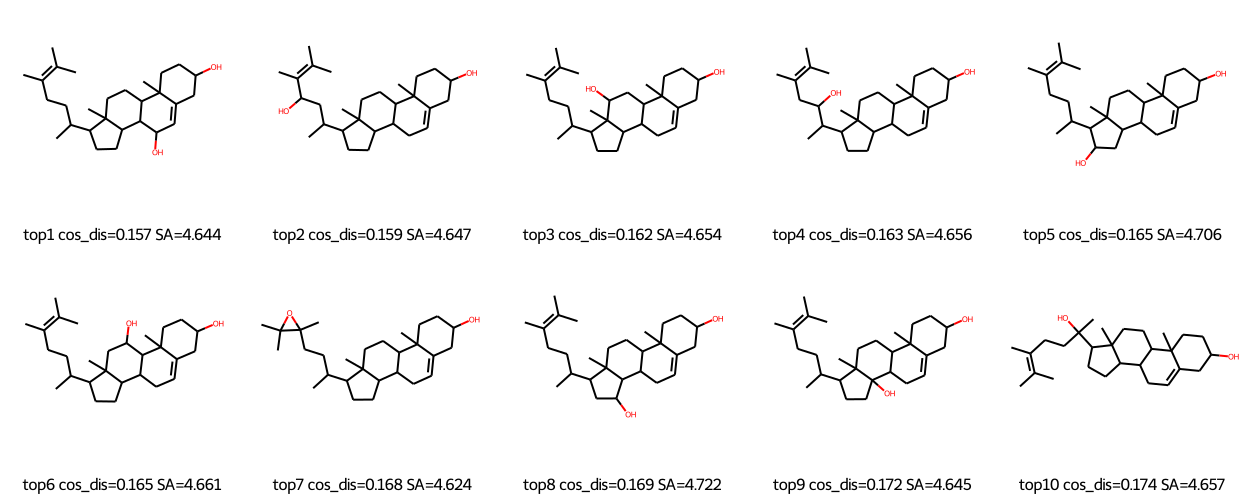

In [373]:
import sys
import os
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))

from SA_Score import sascorer

topk_indices = np.argsort(dist.mean(axis=0))[:10] # get top10 candidates

legends = []
for rnk, idx in enumerate(topk_indices):
    d = dist.mean(axis=0)[idx]
    smi = pred_smis[idx]
    mol = Chem.MolFromSmiles(smi)
    print(f'top{rnk+1}: {smi}')
    legend = f"top{rnk+1} cos_dis={d:.3f} SA={sascorer.calculateScore(mol):.3f}"
    legends.append(legend)
Draw.MolsToGridImage([Chem.MolFromSmiles(pred_smis[i]) for i in topk_indices], molsPerRow=5, subImgSize=(250,250), legends=legends, maxMols=len(topk_indices))

## If you want to see structural annotations on the spectrum
1. Let ICEBERG work in non-binned mode (remove ``--binned-out`` command)
2. Modify the above code block accordingly to handle non-binned output

In [ ]:
topk = 1
idx = topk_indices[topk-1]

ref_binned_sparse = np.vstack((np.where(ref_binned['30'] != 0), ref_binned['30'][np.where(ref_binned['30'] != 0)])).T
ref_binned_sparse[:, 0] /= 10

pred_binned_sparse = np.vstack((np.where(cand_specs[idx]['30'] != 0), cand_specs[idx]['30'][np.where(cand_specs[idx]['30'] != 0)])).T
pred_binned_sparse[:, 0] /= 10

common.plot_compare_ms(ref_binned_sparse, pred_binned_sparse, 'real spec', 'pred spec', 
                       f'Top{topk} recall={np.sum(ref_binned_sparse[:, 0][:, None] == pred_binned_sparse[:, 0][None, :])}/{ref_binned_sparse.shape[0]}', 
                       dpi=500)
# plt.gcf().set_size_inches(18, 7, forward=True)
plt.gca().set_ylim(-1.1, 1.1)

smi = smiles[idx]
engine = fragmentation.FragmentEngine(smi, mol_str_type='smiles')
counter = 0
pred_specs[idx]['30'][:, 1] = pred_specs[idx]['30'][:, 1] / np.max(pred_specs[idx]['30'][:, 1])
for spec, frag in zip(pred_specs[idx]['30'], pred_frags[idx]['30']):
    mz, inten = spec
    draw_dict = engine.get_draw_dict(frag)
    frag_img = Draw.MolToImage(draw_dict["mol"], highlightAtoms=draw_dict["hatoms"], highlightBonds=draw_dict["hbonds"])
    frag_img = np.concatenate((np.array(frag_img), 255 * np.ones((frag_img.size[0], frag_img.size[1], 1), dtype=np.int8)), axis=-1)
    frag_img = np.where(((frag_img[:, :, :3] == np.array([255, 255, 255])[None, None, :]).sum(axis=-1) == 3)[:, :, None], 
                          np.zeros_like(frag_img), frag_img) # make white background transparent
    imagebox = OffsetImage(frag_img, zoom = 0.2)
    ab = AnnotationBbox(imagebox, (mz, - inten), frameon = False)
    plt.gca().add_artist(ab)
    counter += 1
    if counter >= 10:
        break

# Remove common peaks and explain

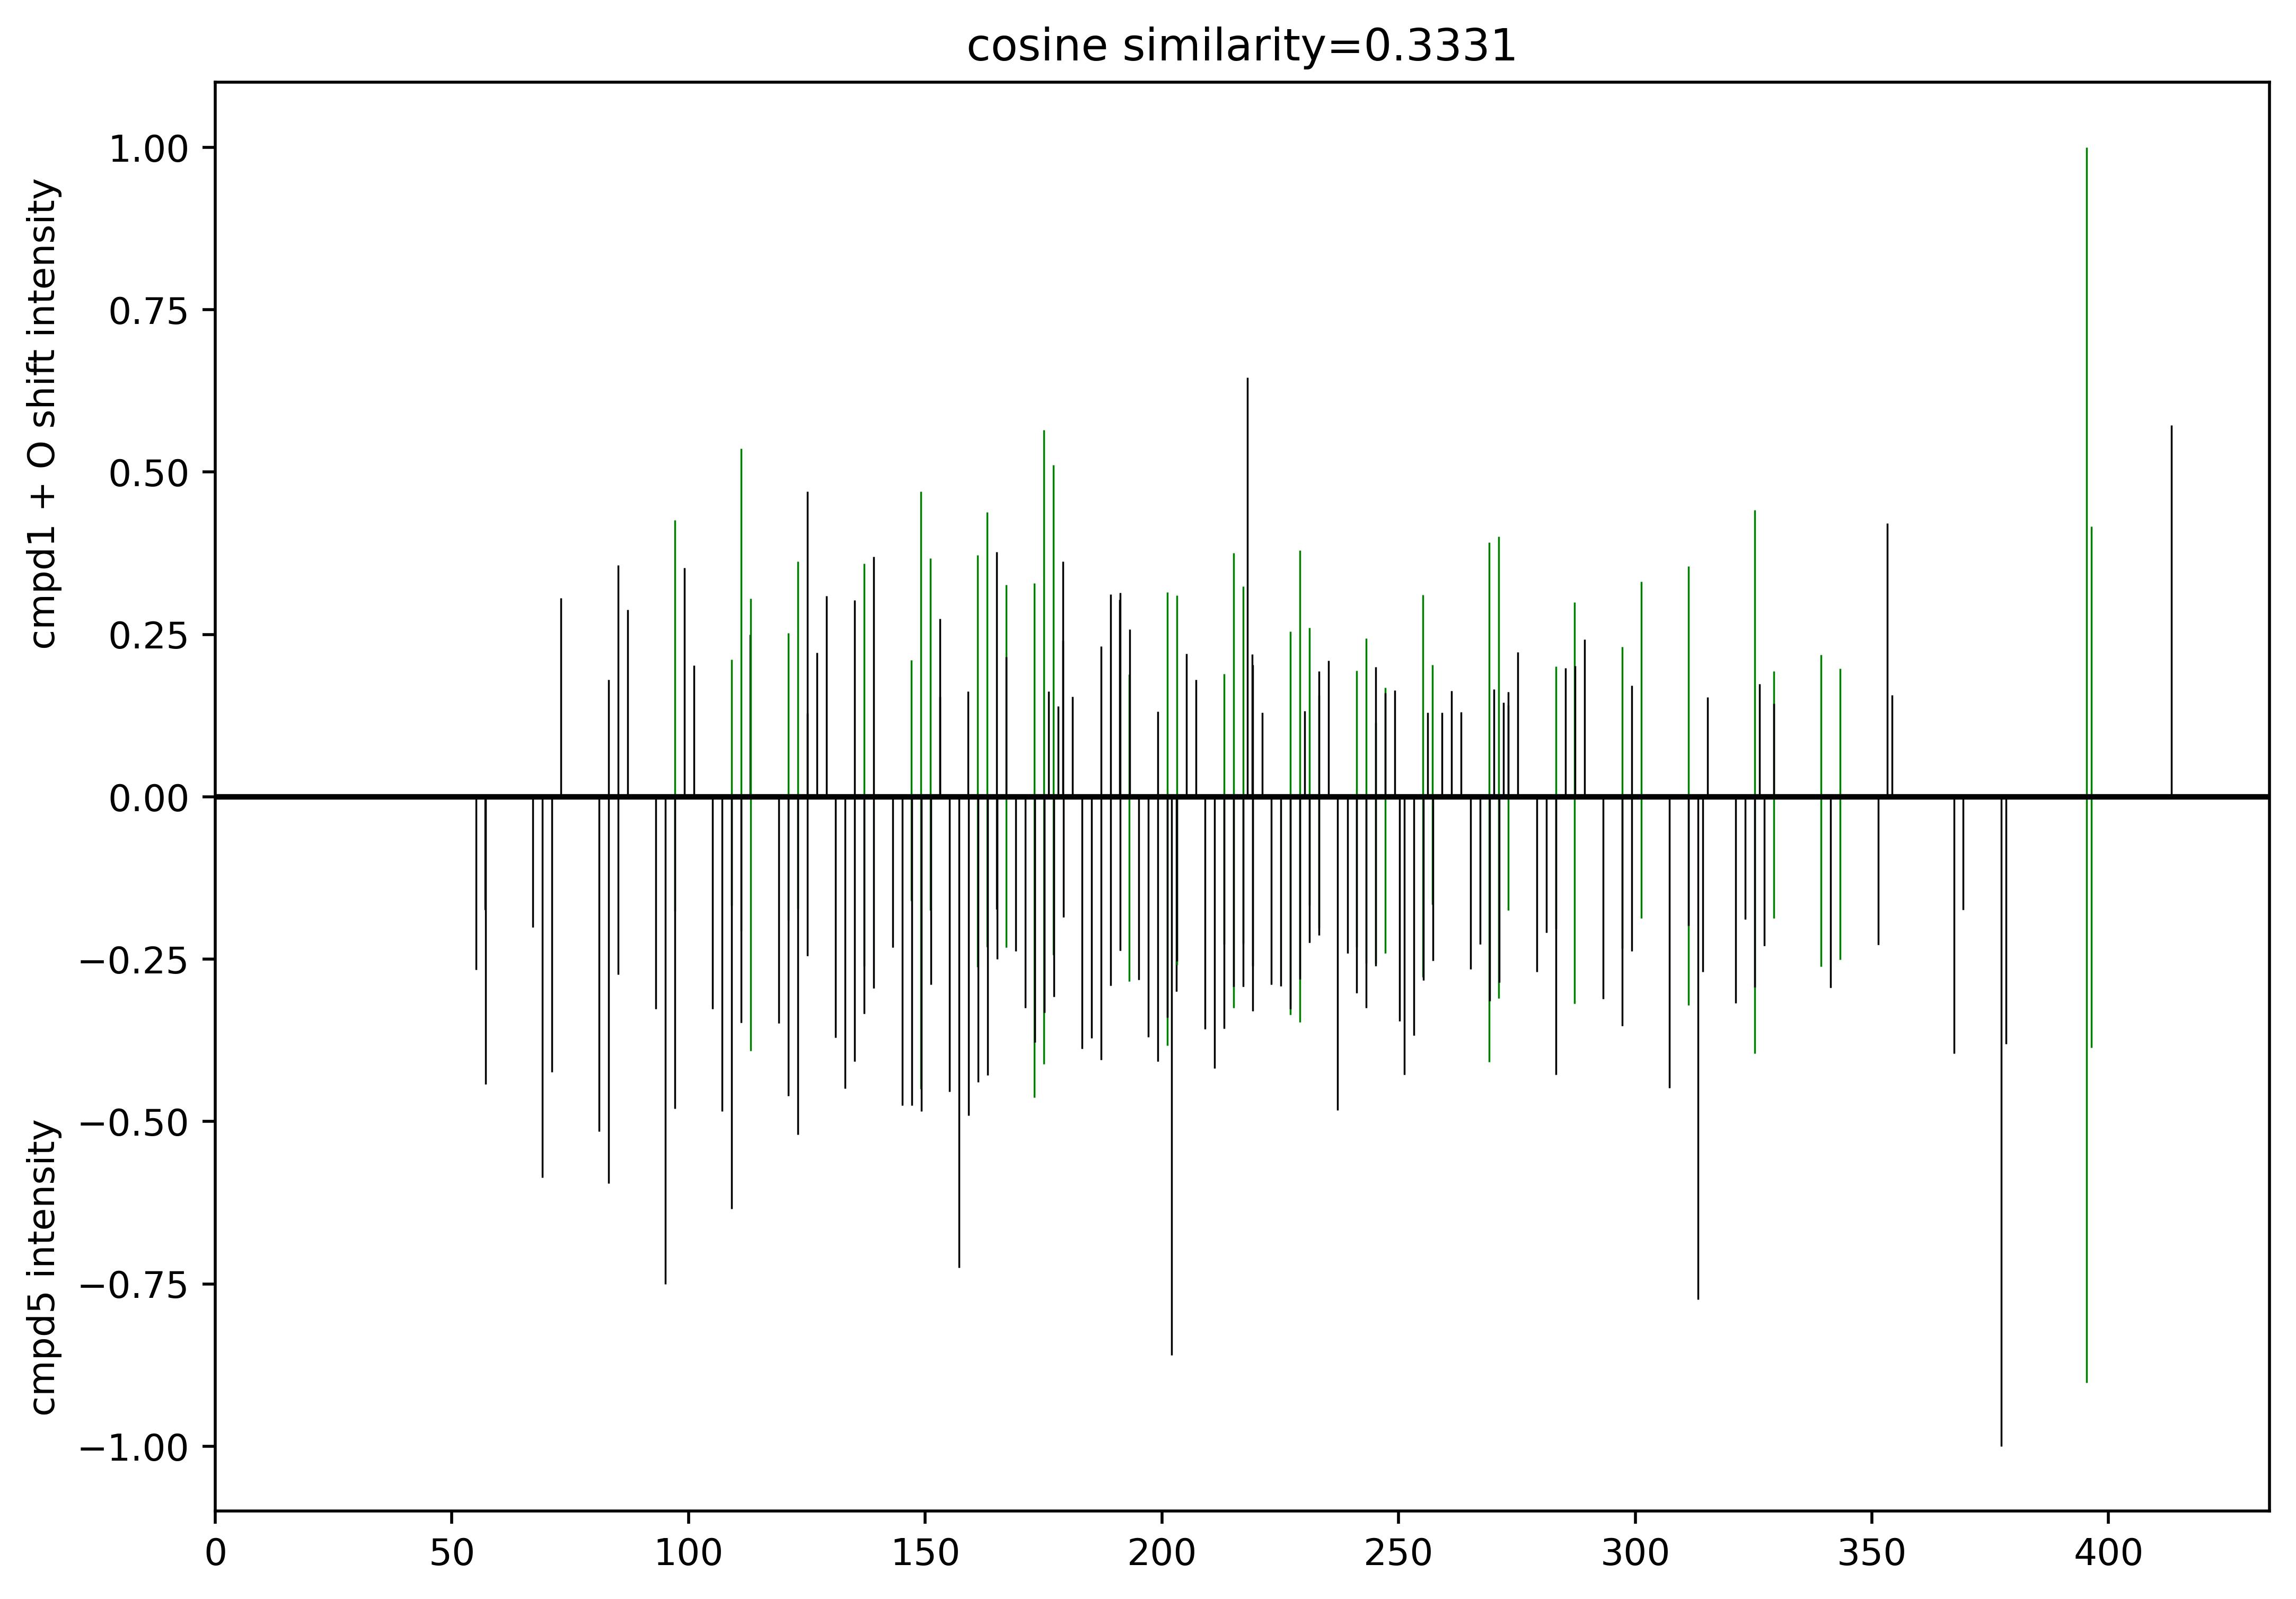

In [374]:
name_a = 'cmpd1'
name_b = 'cmpd5'

def load_spec(cmpd_name):
    current_metadata = all_metadata[cmpd_name]
    # clean peaks from replicates
    clean_ref_spec = None
    for name_suffix in current_metadata['replicate_suffix']:
        spec_df = pd.read_csv(real_spec_dir / (current_metadata['spec_names'][0] +  f'-{name_suffix}.csv'), header=2)
        ref_spec = common.process_spec_file({'parentmass': precursor}, [('30', np.array(spec_df))], merge_specs=False)
        if clean_ref_spec is None:
            clean_ref_spec = ref_spec
        else:
            new_clean_peaks = []
            for mz, inten in clean_ref_spec['30']:
                match = np.abs(mz - ref_spec['30'][:, 0]) / mz < 1e-6 * ppm
                if np.any(match):
                    otherinten = ref_spec['30'][np.where(match), 1]
                    new_clean_peaks.append((mz, inten + otherinten.item()))
            clean_ref_spec = {'30': np.array(new_clean_peaks)}
    binned = {k: common.bin_spectra([v], num_bins)[0] for k, v in clean_ref_spec.items()}
    return clean_ref_spec, binned

spec_a, binned_a = load_spec(name_a)
spec_b, binned_b = load_spec(name_b)

cos = cos_dist_bin([binned_a], binned_b, sparse=False)
# common.plot_compare_ms(spec_a['30'], spec_b['30'], name_a, name_b, f'cosine similarity={cos.item():.4f}', dpi=500)
common.plot_compare_ms(np.stack((spec_a['30'][:, 0] + common.formula_mass('O'), spec_a['30'][:, 1]), axis=-1), spec_b['30'], name_a + ' + O shift', name_b, f'cosine similarity={cos.item():.4f}', dpi=500)

In [375]:
# find different peaks
# unique_peaks = []
# for mz, inten in spec_b['30']:
#     mz_in_spec_a = np.min(np.abs(mz - spec_a['30'][:, 0])) / mz < 1e-6 * ppm
#     if not mz_in_spec_a:
#         unique_peaks.append((mz, inten))
# unique_peaks = np.array(unique_peaks)
# unique_peaks[:, 1] = unique_peaks[:, 1] / unique_peaks[:, 1].max()

# find matched peaks with +O shift
matched_peaks = []
for mz, inten in spec_b['30']:
    shifted_mz_in_spec_a = np.min(np.abs(mz - spec_a['30'][:, 0] - common.formula_mass('O'))) / mz < 1e-6 * ppm
    mz_in_spec_a = np.min(np.abs(mz - spec_a['30'][:, 0])) / mz < 1e-6 * ppm
    if shifted_mz_in_spec_a:
        if mz_in_spec_a:
            a_idx = np.where(np.abs(mz - spec_a['30'][:, 0]) / mz < 1e-6 * ppm)[0][0]
            a_mz, a_inten = spec_a['30'][a_idx]
            if inten > a_inten:
                matched_peaks.append((mz, inten - a_inten))
        else:
            matched_peaks.append((mz, inten))
matched_peaks = np.array(matched_peaks)
matched_peaks[:, 1] = matched_peaks[:, 1] / matched_peaks[:, 1].max()

interested_peaks = matched_peaks

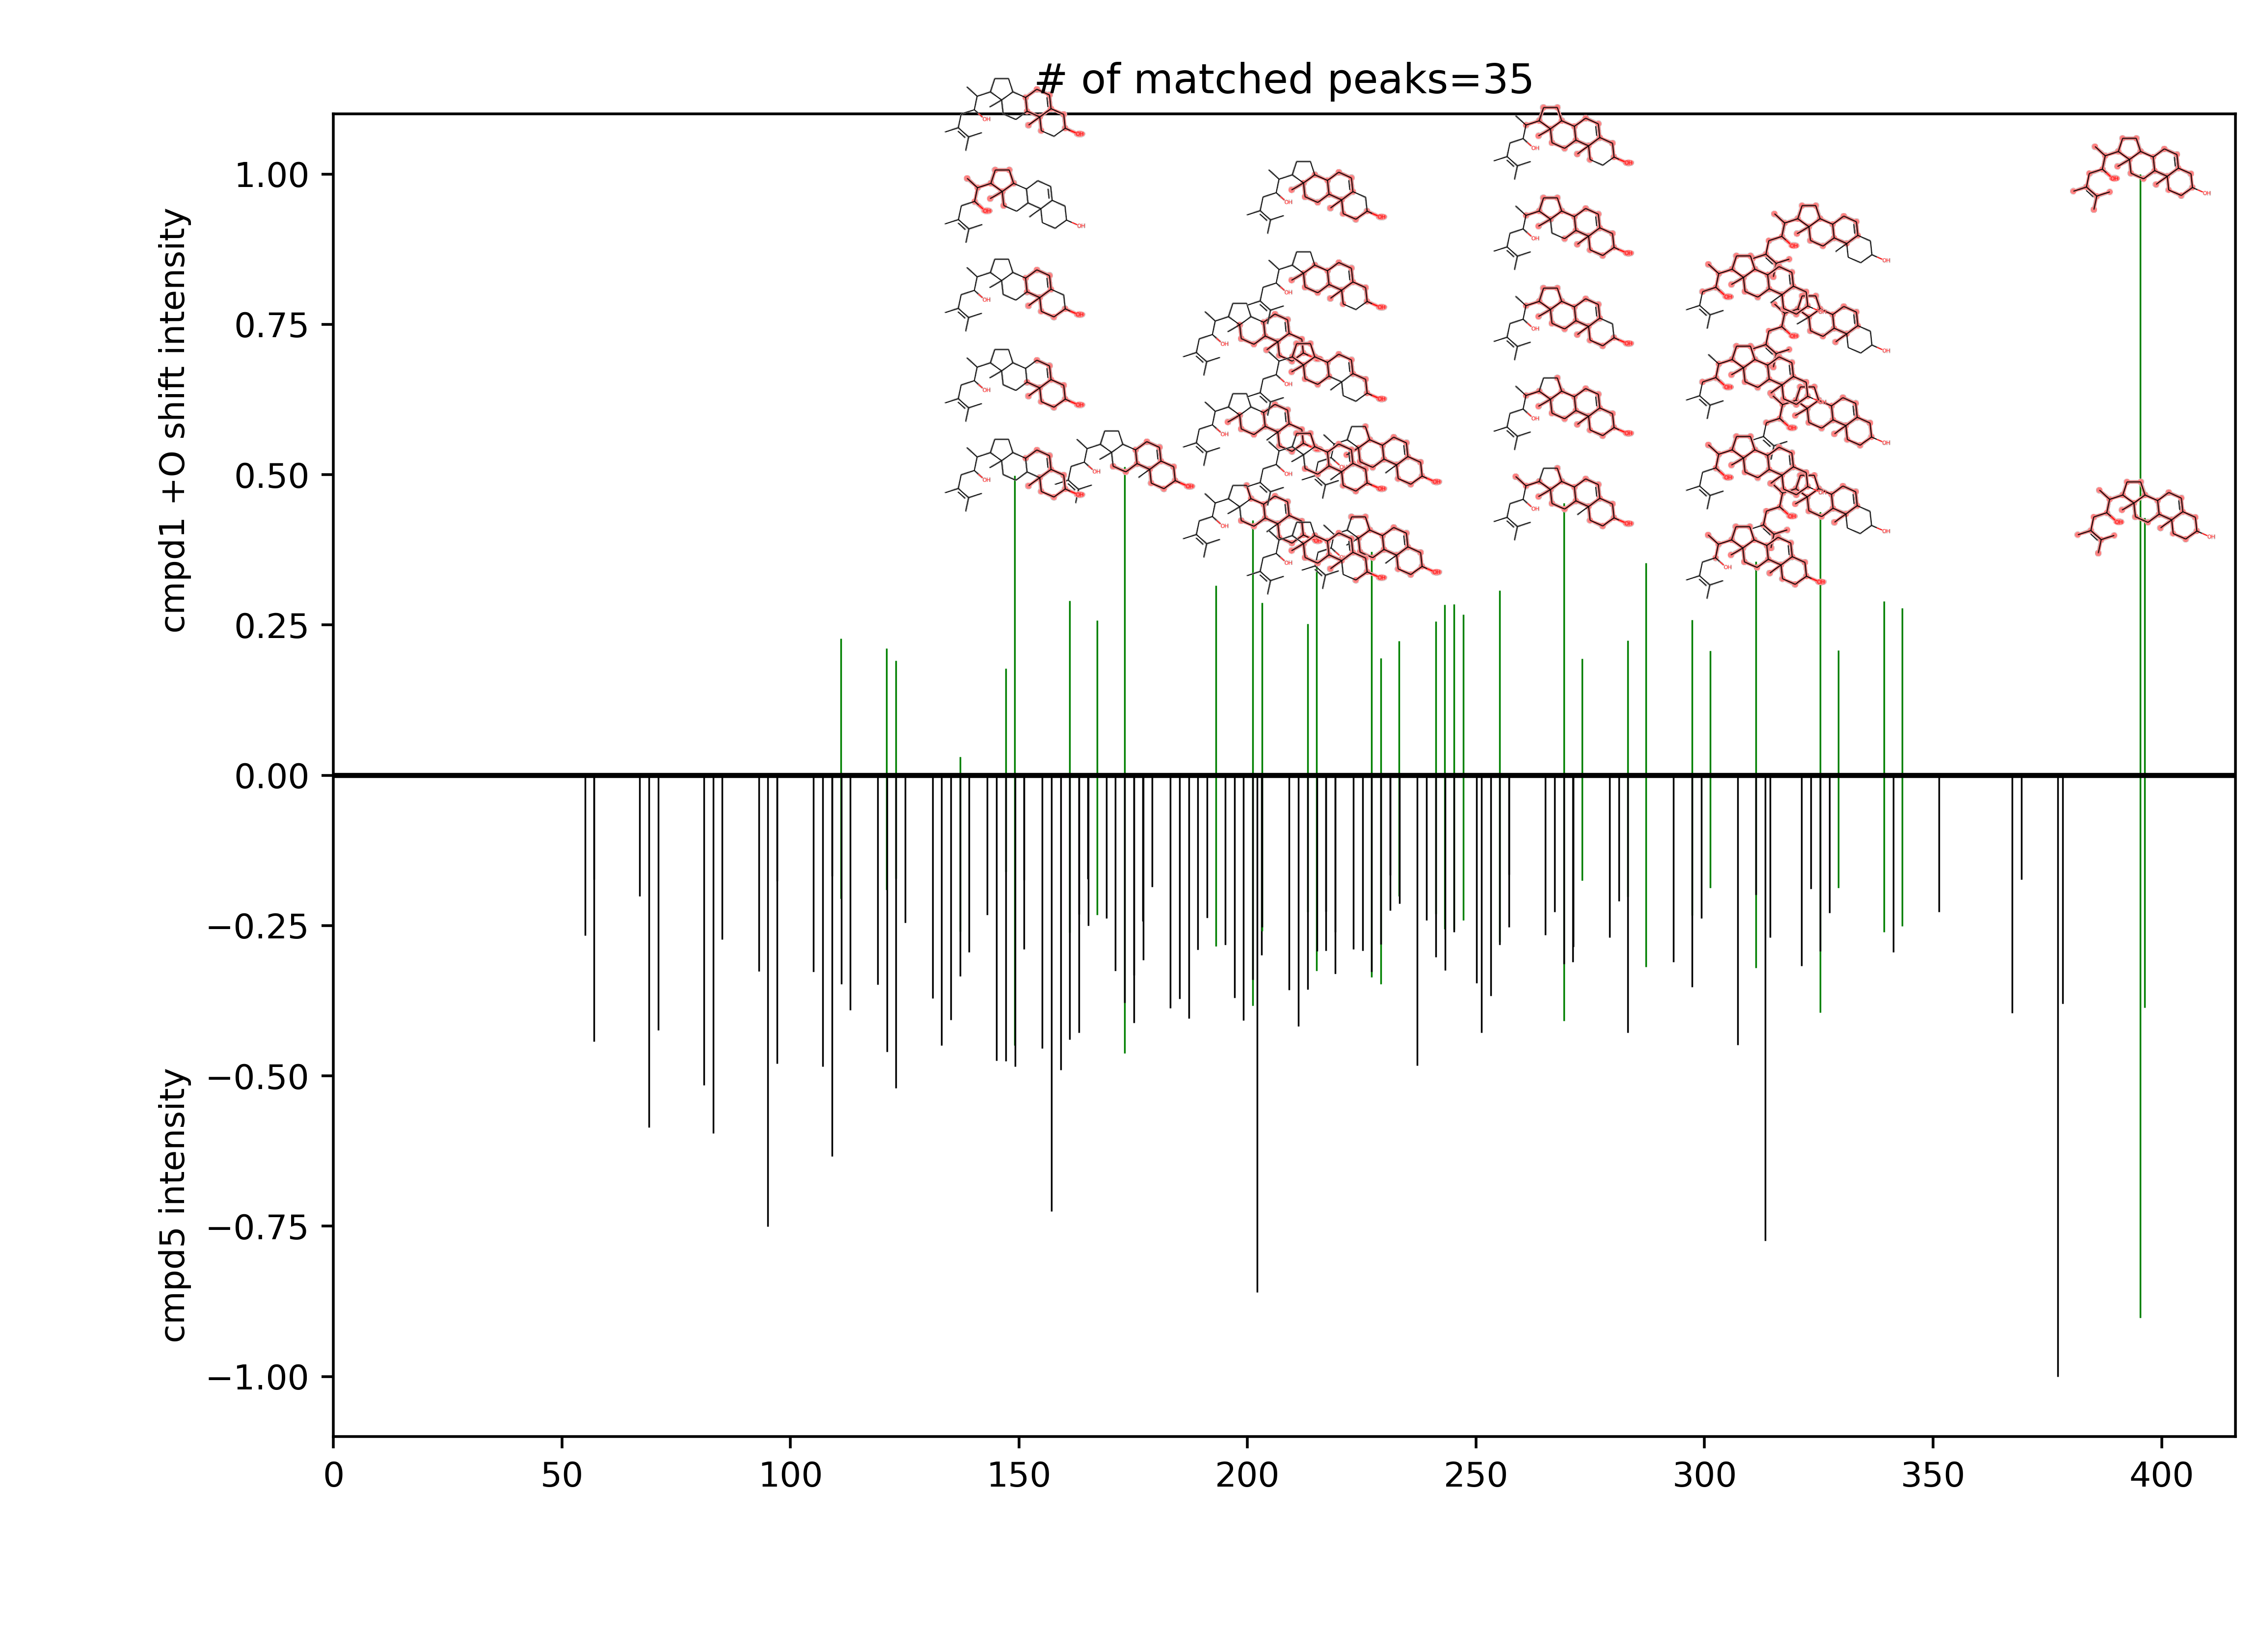

In [381]:
# Plot from known reference peaks

topk = 4
idx = topk_indices[topk-1]
peak_matching = np.abs(interested_peaks[:, 0][:, None] - spec_b['30'][:, 0][None, :]) < interested_peaks[:, 0][:, None] * 1e-6 * ppm
common.plot_compare_ms(interested_peaks, spec_b['30'], name_a + ' +O shift', name_b, f'# of matched peaks={np.sum(peak_matching.max(axis=-1))}', dpi=500)

smi = smiles[idx]
engine = fragmentation.FragmentEngine(smi, mol_str_type='smiles')
counter = 0
pred_specs[idx]['30'][:, 1] = pred_specs[idx]['30'][:, 1] / np.max(pred_specs[idx]['30'][:, 1])
sorted_idx = np.argsort(interested_peaks[:, 1])[::-1]
atom_scores = np.zeros(engine.natoms)
for i in sorted_idx:
    mz, inten = interested_peaks[i]
    peak_matching = np.abs(mz - common.formula_mass('O') - pred_specs[idx]['30'][:, 0]) < mz * 1e-6 * ppm    
    plot_count = 0
    covered_bitmap = 0
    for j in np.where(peak_matching)[0]:
        covered_bitmap = covered_bitmap | pred_frags[idx]['30'][j]  # bit-wise OR
        draw_dict = engine.get_draw_dict(pred_frags[idx]['30'][j])
        frag_img = Draw.MolToImage(draw_dict["mol"], highlightAtoms=draw_dict["hatoms"], highlightBonds=draw_dict["hbonds"])
        frag_img = np.concatenate((np.array(frag_img), 255 * np.ones((frag_img.size[0], frag_img.size[1], 1), dtype=np.int8)), axis=-1)
        frag_img = np.where(((frag_img[:, :, :3] == np.array([255, 255, 255])[None, None, :]).sum(axis=-1) == 3)[:, :, None], 
                              np.zeros_like(frag_img), frag_img) # make white background transparent
        imagebox = OffsetImage(frag_img, zoom = 0.15)
        ab = AnnotationBbox(imagebox, (mz, inten + plot_count * 0.15), frameon = False)
        plt.gca().add_artist(ab)
        plot_count += 1
    covered_atoms = engine.get_present_atoms(covered_bitmap)[0]
    atom_scores[covered_atoms] += inten
    counter += 1
    if counter >= 10:
        break

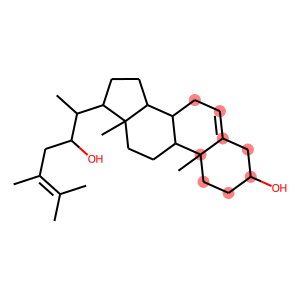

In [380]:
Draw.MolToImage(engine.mol, highlightAtoms=(np.where(atom_scores > atom_scores.max() - 0.1)[0]).tolist())

In [379]:
atom_scores[np.argsort(atom_scores)[::-1][:20]]

array([9.56100537, 9.56100537, 9.56100537, 9.56100537, 9.56100537,
       9.56100537, 9.56100537, 9.56100537, 8.93189904, 8.93189904,
       8.75444175, 8.67635538, 8.22579606, 8.17910987, 7.95146522,
       7.95146522, 7.92715831, 7.50271904, 7.40585083, 7.13079262])

In [222]:
draw_dict["hatoms"]

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 29]

In [ ]:
# topk_unique_peaks = np.argsort(unique_peaks[:, 1])[::-1][:20]
# topk_unique_peaks = unique_peaks[topk_unique_peaks, :]

matched_num = []
for idx in range(len(pred_specs)):
    peak_matching = np.abs(interested_peaks[:, 0][:, None] - pred_specs[idx]['30'][:, 0][None, :]) < interested_peaks[:, 0][:, None] * 1e-6 * ppm
    matched_num.append(np.sum(peak_matching.max(axis=-1) * interested_peaks[:, 1]))
matched_num = np.array(matched_num)
ranked_idx = np.argsort(matched_num)[::-1]
list(zip(ranked_idx, matched_num[ranked_idx]))

In [ ]:
# topk = 6
# idx = topk_indices[topk-1]
idx = 1
peak_matching = np.abs(interested_peaks[:, 0][:, None] - pred_specs[idx]['30'][:, 0][None, :]) < interested_peaks[:, 0][:, None] * 1e-6 * ppm
common.plot_compare_ms(interested_peaks, pred_specs[idx]['30'], name_b, f'top {topk} pred', f'# of matched peaks={np.sum(peak_matching.max(axis=-1))}', dpi=500)

smi = smiles[idx]
engine = fragmentation.FragmentEngine(smi, mol_str_type='smiles')
counter = 0
pred_specs[idx]['30'][:, 1] = pred_specs[idx]['30'][:, 1] / np.max(pred_specs[idx]['30'][:, 1])
sorted_idx = np.argsort(interested_peaks[:, 1])[::-1]
for i in sorted_idx:
    mz, inten = interested_peaks[i]
    plot_count = 0
    for j in np.where(peak_matching[i])[0]:
        draw_dict = engine.get_draw_dict(pred_frags[idx]['30'][j])
        frag_img = Draw.MolToImage(draw_dict["mol"], highlightAtoms=draw_dict["hatoms"], highlightBonds=draw_dict["hbonds"])
        frag_img = np.concatenate((np.array(frag_img), 255 * np.ones((frag_img.size[0], frag_img.size[1], 1), dtype=np.int8)), axis=-1)
        frag_img = np.where(((frag_img[:, :, :3] == np.array([255, 255, 255])[None, None, :]).sum(axis=-1) == 3)[:, :, None], 
                              np.zeros_like(frag_img), frag_img) # make white background transparent
        imagebox = OffsetImage(frag_img, zoom = 0.15)
        ab = AnnotationBbox(imagebox, (mz, inten + plot_count * 0.15), frameon = False)
        plt.gca().add_artist(ab)
        plot_count += 1
    counter += 1
    if counter >= 20:
        break

# for spec, frag, matched in zip(pred_specs[idx]['30'], pred_frags[idx]['30'], peak_matching.max(axis=0)):
#     if not matched:
#         continue
#     mz, inten = spec
#     draw_dict = engine.get_draw_dict(frag)
#     frag_img = Draw.MolToImage(draw_dict["mol"], highlightAtoms=draw_dict["hatoms"], highlightBonds=draw_dict["hbonds"])
#     frag_img = np.concatenate((np.array(frag_img), 255 * np.ones((frag_img.size[0], frag_img.size[1], 1), dtype=np.int8)), axis=-1)
#     frag_img = np.where(((frag_img[:, :, :3] == np.array([255, 255, 255])[None, None, :]).sum(axis=-1) == 3)[:, :, None], 
#                           np.zeros_like(frag_img), frag_img) # make white background transparent
#     imagebox = OffsetImage(frag_img, zoom = 0.15)
#     ab = AnnotationBbox(imagebox, (mz, - inten), frameon = False)
#     plt.gca().add_artist(ab)
#     counter += 1
#     if counter >= 15:
#         break